In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from numpy import array
from datetime import datetime
import seaborn as sns

2022-10-13 16:32:23.888803: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-13 16:32:23.888829: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
sns.set_style("darkgrid")
cm = 1/2.54 
colors = ['#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB']
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

### Replace missing values with Zero and Group by month

In [3]:
dateparse = lambda x: datetime.strptime(x, '%d-%b-%y')
df = pd.read_csv('../data_region.csv', parse_dates=['date'], date_parser=dateparse)
df = df.set_index('date')

In [4]:
df1 = df.loc["2015-02-01":"2016-09-01"]
df2 = df.loc["2016-03-01":"2017-09-30"]
df3 = df.loc["2017-09-01":"2019-04-02"]

### Create batches of training data (12 months)

In [5]:
def split_sequence(sequence, n_steps_in, n_steps_out, slide):
    X, y = list(), list()
    for i in range(0, len(sequence), slide):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Define and fit LSTM model 

In [6]:
def fit(X, y, n_steps_in, n_steps_out):
    callback = EarlyStopping(monitor='loss', patience=50)
    model = Sequential()
    model.add(LSTM(units=50, activation='relu', input_shape=(n_steps_in, 1)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=250, batch_size=32, callbacks=[callback])
    
    loss_per_epoch = model.history.history['loss']
    plt.plot(range(len(loss_per_epoch)),loss_per_epoch)
    return model 

In [7]:
def train_predict(dataset, test, actual):
    n_steps_in, n_steps_out, slide = 7, 7, 1
    X, y = split_sequence(dataset, n_steps_in, n_steps_out, slide)
    
    # flatten input and output
    n_input = X.shape[1] * X.shape[2]
    X = X.reshape((X.shape[0], n_input))
    n_output = y.shape[1] * y.shape[2]
    y = y.reshape((y.shape[0], n_output))
    
    print(X[0], y[0], len(X[0]), len(y[0]))
    model = fit(X, y, n_input, n_output)
    
    x_input = dataset[-n_steps_in:]
    x_input = x_input.reshape((1, n_input, 1))
    pred = model.predict(x_input).reshape(-1, 4)
    pred = scaler.inverse_transform(pred)
    print(x_input,pred)
    
    mae, rmse, smape = list(), list(), list()  
    for i in range(0, len(test), n_steps_in):
        mae_aux, rmse_aux, smape_aux = measure_error(actual, pred, n_steps_in, i)
        mae.append(mae_aux), rmse.append(rmse_aux), smape.append(smape_aux)
        print(actual[i:i+n_steps_in], pred, mae, rmse, smape)
        x_input = array(test[i:n_steps_in+i])
        x_input = x_input.reshape((1, n_input, 1))
        pred = model.predict(x_input).reshape(-1, 4)
        pred = scaler.inverse_transform(pred)
        #print(x_input, current_pred)
    
    return mae, rmse, smape

In [8]:
def sMAPE(actual, predicted):
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
    return round(np.mean(np.abs(predicted - actual) / ((np.abs(predicted) + np.abs(actual))/2))*100, 2)

In [9]:
def measure_error(actual, pred, step, index):
    print(actual[index:index+step], pred)
    mae = mean_absolute_error(array(actual[index:index+step]), pred)
    rmse = np.sqrt(mean_squared_error(array(actual[index:index+step]), pred))
    smape = sMAPE(array(actual[index:index+step]), pred)
    return mae, rmse, smape

### Normalize Data Set and Split Train and Test

[0.38082194 0.51134014 0.45888174 0.50939846 0.3616438  0.6618557
 0.72532904 0.76503754 0.35616434 0.48865974 0.43914473 0.5545113
 0.27123284 0.5237113  0.4638158  0.5338347  0.2767123  0.51958764
 0.59539473 0.5526316  0.41643834 0.6041237  0.5246712  0.62030077
 0.41643834 0.5917525  0.50822365 0.60526323] [0.33424652 0.5917525  0.52960527 0.47556388 0.38904107 0.70515466
 0.71710527 0.70864654 0.20821917 0.61030924 0.5032896  0.70676684
 0.44109595 0.5752578  0.7598685  0.419173   0.3616438  0.63711345
 0.5937501  0.5545113  0.31780827 0.5546392  0.67763174 0.48684216
 0.3726027  0.4597938  0.5115131  0.49248123] 28 28
Epoch 1/250


2022-10-13 16:32:25.516659: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-13 16:32:25.516694: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2022-10-13 16:32:25.516983: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


16/16 [==============================] - 1s 11ms/step - loss: 0.1256
Epoch 2/250
16/16 [==============================] - 0s 10ms/step - loss: 0.0732
Epoch 3/250
16/16 [==============================] - 0s 11ms/step - loss: 0.0292
Epoch 4/250
16/16 [==============================] - 0s 12ms/step - loss: 0.0174
Epoch 5/250
16/16 [==============================] - 0s 12ms/step - loss: 0.0144
Epoch 6/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0140
Epoch 7/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0139
Epoch 8/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0140
Epoch 9/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0139
Epoch 10/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0139
Epoch 11/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0139
Epoch 12/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0140
Epoch 13/250
16/16 [=================

16/16 [==============================] - 0s 13ms/step - loss: 0.0136
Epoch 102/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0135
Epoch 103/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0135
Epoch 104/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0134
Epoch 105/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0134
Epoch 106/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0135
Epoch 107/250
16/16 [==============================] - 0s 17ms/step - loss: 0.0136
Epoch 108/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0134
Epoch 109/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0135
Epoch 110/250
16/16 [==============================] - 0s 15ms/step - loss: 0.0134
Epoch 111/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0135
Epoch 112/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0134
Epoch 113/250
16/1

[[ 520  961 1260 1097]
 [ 489  982 1208 1102]
 [ 508  893 1233 1082]
 [ 518  920 1294 1128]
 [ 474  849 1279 1062]
 [ 506  892 1204 1051]
 [ 514  909 1197  958]] [[ 444.74374  884.86725 1280.8497  1049.1965 ]
 [ 437.85782  883.31335 1253.6128  1005.7574 ]
 [ 451.41995  903.68964 1304.7836  1059.0966 ]
 [ 458.44174  906.97144 1305.2112  1045.976  ]
 [ 442.37537  866.6515  1263.9769  1024.018  ]
 [ 453.47104  885.7376  1277.3807  1026.4626 ]
 [ 445.4459   895.18494 1289.6654  1058.6249 ]]
[[ 520  961 1260 1097]
 [ 489  982 1208 1102]
 [ 508  893 1233 1082]
 [ 518  920 1294 1128]
 [ 474  849 1279 1062]
 [ 506  892 1204 1051]
 [ 514  909 1197  958]] [[ 444.74374  884.86725 1280.8497  1049.1965 ]
 [ 437.85782  883.31335 1253.6128  1005.7574 ]
 [ 451.41995  903.68964 1304.7836  1059.0966 ]
 [ 458.44174  906.97144 1305.2112  1045.976  ]
 [ 442.37537  866.6515  1263.9769  1024.018  ]
 [ 453.47104  885.7376  1277.3807  1026.4626 ]
 [ 445.4459   895.18494 1289.6654  1058.6249 ]] [49.030319213867

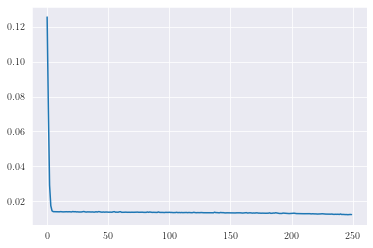

In [10]:
df1 = df1.pivot_table('count', 'date', 'region')
dataset = df1[['Alentejo e Algarve', 'Centro', 'Lisboa', 'Norte']].values
dataset = df1[['Alentejo e Algarve', 'Centro', 'Lisboa', 'Norte']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
mae1, rmse1, smape1 = train_predict(dataset[:509], dataset[509:], df1[['Alentejo e Algarve', 'Centro', 'Lisboa', 'Norte']][509:].values)

[0.23465705 0.5397849  0.63978505 0.4580152  0.4223827  0.48172045
 0.5286739  0.41221368 0.28519857 0.47526884 0.41756272 0.58969474
 0.3357401  0.57849455 0.3835125  0.40458012 0.19855595 0.26666665
 0.24551964 0.41221368 0.26714802 0.32688177 0.31003594 0.40648854
 0.38989174 0.5999999  0.5250895  0.54770994] [0.32129967 0.62365603 0.4283154  0.5458014  0.49458492 0.4602151
 0.3297491  0.35687017 0.44043326 0.49892473 0.44086027 0.5954199
 0.48736465 0.5634408  0.5985663  0.63549614 0.49458492 0.5268817
 0.4283154  0.38549614 0.4440434  0.52903223 0.5268817  0.41030538
 0.5559567  0.6086023  0.5878136  0.57061076] 28 28
Epoch 1/250
16/16 [==============================] - 1s 13ms/step - loss: 0.1623
Epoch 2/250
16/16 [==============================] - 0s 13ms/step - loss: 0.1057
Epoch 3/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0585
Epoch 4/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0339
Epoch 5/250
16/16 [==========================

Epoch 192/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0211
Epoch 193/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0209
Epoch 194/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0209
Epoch 195/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0210
Epoch 196/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0210
Epoch 197/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0210
Epoch 198/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0210
Epoch 199/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0210
Epoch 200/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0208
Epoch 201/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0208
Epoch 202/250
16/16 [==============================] - 0s 18ms/step - loss: 0.0209
Epoch 203/250
16/16 [==============================] - 0s 16ms/step - loss: 0.0209
Epoc

[[ 448  858 1100  951]
 [ 412  855 1189  969]
 [ 438  790 1126  934]
 [ 395  753 1140  915]
 [ 421  779 1196  963]
 [ 388  833 1267  950]
 [ 500  859 1357  995]] [[ 442.32016  874.8059  1290.043   1040.3424 ]
 [ 442.08453  875.33826 1292.6909  1040.5868 ]
 [ 440.7535   874.43646 1288.8604  1043.2992 ]
 [ 437.4143   869.7338  1288.4249  1043.5164 ]
 [ 438.48743  867.403   1292.225   1049.8116 ]
 [ 437.3211   864.5146  1281.1747  1038.9747 ]
 [ 436.78345  860.9147  1267.3297  1031.358  ]]
[[ 448  858 1100  951]
 [ 412  855 1189  969]
 [ 438  790 1126  934]
 [ 395  753 1140  915]
 [ 421  779 1196  963]
 [ 388  833 1267  950]
 [ 500  859 1357  995]] [[ 442.32016  874.8059  1290.043   1040.3424 ]
 [ 442.08453  875.33826 1292.6909  1040.5868 ]
 [ 440.7535   874.43646 1288.8604  1043.2992 ]
 [ 437.4143   869.7338  1288.4249  1043.5164 ]
 [ 438.48743  867.403   1292.225   1049.8116 ]
 [ 437.3211   864.5146  1281.1747  1038.9747 ]
 [ 436.78345  860.9147  1267.3297  1031.358  ]] [35.826745169503

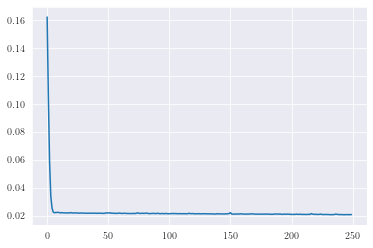

In [11]:
df2 = df2.pivot_table('count', 'date', 'region')
dataset = df2[['Alentejo e Algarve', 'Centro', 'Lisboa', 'Norte']].values
dataset = df2[['Alentejo e Algarve', 'Centro', 'Lisboa', 'Norte']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
mae2, rmse2, smape2 = train_predict(dataset[:509], dataset[509:], df2[['Alentejo e Algarve', 'Centro', 'Lisboa', 'Norte']][509:].values)

[0.340625   0.17045456 0.12322283 0.06815517 0.690625   0.20328277
 0.2085309  0.12103415 0.596875   0.1098485  0.06919432 0.13983548
 0.49375004 0.18181819 0.17345977 0.19271445 0.32812506 0.09469694
 0.05023706 0.08460641 0.46875006 0.16035348 0.13080573 0.30669808
 0.403125   0.1691919  0.13364935 0.30434787] [0.5531251  0.16035348 0.1592418  0.22914219 0.45625    0.17929286
 0.10521328 0.1692127  0.42187506 0.20833331 0.04644561 0.21974146
 0.41562504 0.23737377 0.13080573 0.19506466 0.43750006 0.13005048
 0.09763038 0.13631022 0.29375    0.20202023 0.1592418  0.12573445
 0.371875   0.19191915 0.13270152 0.06345475] 28 28
Epoch 1/250
16/16 [==============================] - 1s 13ms/step - loss: 0.0921
Epoch 2/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0522
Epoch 3/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0237
Epoch 4/250
16/16 [==============================] - 0s 14ms/step - loss: 0.0158
Epoch 5/250
16/16 [=======================

Epoch 192/250
16/16 [==============================] - 0s 12ms/step - loss: 0.0117
Epoch 193/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0117
Epoch 194/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0117
Epoch 195/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0117
Epoch 196/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0117
Epoch 197/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0116
Epoch 198/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0116
Epoch 199/250
16/16 [==============================] - 0s 12ms/step - loss: 0.0116
Epoch 200/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0116
Epoch 201/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0116
Epoch 202/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0116
Epoch 203/250
16/16 [==============================] - 0s 13ms/step - loss: 0.0116
Epoc

[[ 405  971 1524 1260]
 [ 436  983 1554 1342]
 [ 391 1009 1400 1252]
 [ 453  981 1382 1270]
 [ 370  880 1448 1188]
 [ 411  978 1516 1219]
 [ 429  957 1580 1160]] [[ 432.10986  974.0573  1505.3518  1245.3695 ]
 [ 428.81628  968.823   1492.4578  1236.2836 ]
 [ 427.60013  980.5242  1512.8971  1227.9655 ]
 [ 430.08456  970.3281  1492.1436  1225.7623 ]
 [ 423.25696  952.7593  1463.0912  1209.5133 ]
 [ 425.73987  953.2104  1462.513   1208.5112 ]
 [ 420.45966  956.6483  1468.822   1200.6776 ]]
[[ 405  971 1524 1260]
 [ 436  983 1554 1342]
 [ 391 1009 1400 1252]
 [ 453  981 1382 1270]
 [ 370  880 1448 1188]
 [ 411  978 1516 1219]
 [ 429  957 1580 1160]] [[ 432.10986  974.0573  1505.3518  1245.3695 ]
 [ 428.81628  968.823   1492.4578  1236.2836 ]
 [ 427.60013  980.5242  1512.8971  1227.9655 ]
 [ 430.08456  970.3281  1492.1436  1225.7623 ]
 [ 423.25696  952.7593  1463.0912  1209.5133 ]
 [ 425.73987  953.2104  1462.513   1208.5112 ]
 [ 420.45966  956.6483  1468.822   1200.6776 ]] [75.010882786342

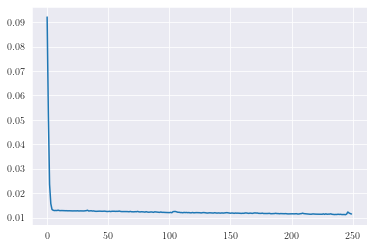

In [12]:
df3 = df3.pivot_table('count', 'date', 'region')
dataset = df3[['Alentejo e Algarve', 'Centro', 'Lisboa', 'Norte']].values
dataset = df3[['Alentejo e Algarve', 'Centro', 'Lisboa', 'Norte']].astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
mae3, rmse3, smape3 = train_predict(dataset[:509], dataset[509:], df3[['Alentejo e Algarve', 'Centro', 'Lisboa', 'Norte']][509:].values)

In [13]:
mae = mae1 + mae2 + mae3
rmse = rmse1 + rmse2 + rmse3
smape = smape1 + smape2 + smape3

### Calculate Error

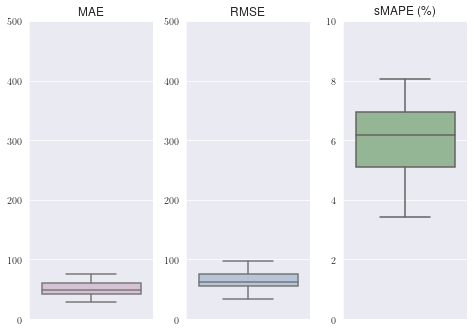

In [14]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(17*cm,12*cm))
sns.boxplot(ax=axes[0], y=mae, color='thistle', showfliers=False)
axes[0].set_title('MAE')
axes[0].set(ylim=(0, 500))
sns.boxplot(ax=axes[1], y=rmse, color='lightsteelblue', showfliers=False)
axes[1].set_title('RMSE')
axes[1].set(ylim=(0, 500))
sns.boxplot(ax=axes[2], y=smape, color='darkseagreen', showfliers=False)
axes[2].set_title('sMAPE (\%)')
axes[2].set(ylim=(0, 10))
plt.tight_layout()

In [17]:
emer_lstm_day_region_mul = [mae,rmse,smape]
%store emer_lstm_day_region_mul

Stored 'emer_lstm_day_region_mul' (list)
